# Mobile Games A/B Testing with Cookie Cats

## Introduction
- Cookie Cats is a popular mobile puzzle game in which the player must connect tiles of the same color in order to clear the board and win the level. 
- As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase.
- For this project, I will analyze the result, more specificly the impact on player _retention_, of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40.
- The definition of player _retention_ in this project is the player comes back and play the game after installing.

## Scope

### Problem
- By changing the first gate in Cookie Cats from level 30 to level 40, will the player retention rate increase or decrease? 

### Goal
- Identify the association between versions and retention rates for one day and for seven days.
    - association will be based on significance threshold 5%
- Decide if the game should set up the first gate at level 30 or at level 40.
- (Further research needed) Create user segmentations where different groups of users have the first gate set up at different levels.

### Action
1. Pick two groups of users randomly, each with the same number of users. The control group will install the gate_30 version where the first gate appears at level 30, and the experimental group will install the gate_40 version where the first gate appears at level 40.
2. Count the number of rounds each group of users play during the first 14 days after install.
3. See if the user come back and play the game again the next day and the seventh day after installing.
4. Use Chi Sqaure contingency test to calculate the association between the two versions and retention_1 and retention_7.

### Data
- I will use 'cookie_cats.csv' dateset. It contains five columns:
    1. userid: a unique number that identifies the player
    2. version: whether the user is in the control group (gate_30, the first gate appears at level 30) or in the experimental group (gate_40, the first gate appears at level 40)
    3. sum_gamerounds: the number of game rounds played by the player during the first 14 days after install.
    4. retention_1: whether the player comes back and plays 1 day after installing.
    5. retention_7: whether the player comes back and plays 7 days after installing.

### Types Analysis Done
- Description
- Optimization
- Behavior Change

## Conclusion
- There is no significant association between the two versions of game and the retention in one day; however, there is a significant association between the two version and the retention in seven days, which means that the change of the gate in the game will impact on users' retention in the longer term, although seven days is still too short to judge the overall impact.
- The experimental group's retention is lower than the control group, meaning users are more likely to come back after seven days if the gate appears at level 30. However, it can be considered that a gate set up at a lower level will increase retention, since currently 50% of players play 16 times or fewer.

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
df = pd.read_csv('cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [30]:
# check if there is any null value
df.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

No null values found in this DataFrame.

In [4]:
df.dtypes

userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object

The data type for 'userid' column is int64; however, it should be categorical since it is an identification for each user. I will convert it to string.

In [31]:
df['userid'] = df['userid'].astype('str')

In [32]:
df.shape

(90189, 5)

The dataFrame has five columns and 90189 rows. I will check if there is any duplicates.

In [10]:
df.duplicated().sum()

0

No duplicate rows in this dataframe.

In [11]:
df.describe(include='all')

,userid,version,sum_gamerounds,retention_1,retention_7
count,90189,90189,90189.000000,90189,90189
unique,90189,2,NaN,2,2
top,6397153,gate_40,NaN,False,False
freq,1,45489,NaN,50036,73408
mean,NaN,NaN,51.872457,NaN,NaN
std,NaN,NaN,195.050858,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,5.000000,NaN,NaN
50%,NaN,NaN,16.000000,NaN,NaN
75%,NaN,NaN,51.000000,NaN,NaN


Looking at the describe result, there are some interesting points:
- the 'version' column has two unique values, gate_30 and gate_40. Gate_40 has 45489 frequency in the column meaning gate_30 has 44700 frequency. There is a 789 difference, meaning 789 more users in the experimental group.
- in the 'sum_gamerounds' column, the mean is around 51.87, which is close to the 75 percentile of entire numbers of game rounds. The maximum value is 49854, which is **significantly higher** than the median and the mean. It means that this column's data is extremely **left skewed** and there might be outliers as well.
- 'retention_1' column has 50036 False value where 'retention_7' column has 73408 False value; however, we still need to calculate the significance result.

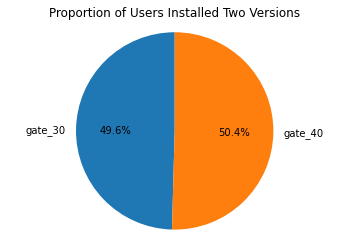

<Figure size 432x288 with 0 Axes>

In [15]:
labels = ['gate_30', 'gate_40']
versions = [len(df[df.version == 'gate_30']), len(df[df.version == 'gate_40'])]

plt.pie(versions, labels=labels, autopct='%0.1f%%', startangle=90)
plt.axis('equal')
plt.title('Proportion of Users Installed Two Versions')
plt.show()
plt.clf()

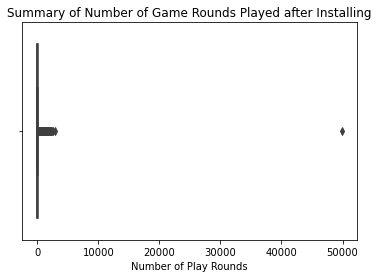

<Figure size 432x288 with 0 Axes>

In [17]:
sns.boxplot(data=df, x='sum_gamerounds')
plt.title('Summary of Number of Game Rounds Played after Installing')
plt.xlabel('Number of Play Rounds')
plt.show()
plt.clf()

It is clear that the maximum value of 49854 is an outlier. I will drop this outlier row and plot another boxplot.

In [22]:
df.loc[lambda df: df['sum_gamerounds'] == 49854]

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,False,True


In [34]:
df = df.drop([57702])

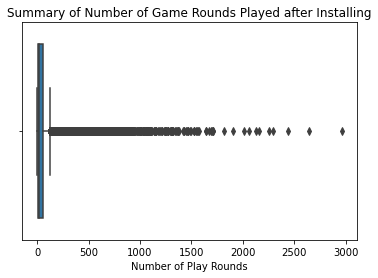

<Figure size 432x288 with 0 Axes>

In [35]:
sns.boxplot(data=df, x='sum_gamerounds')
plt.title('Summary of Number of Game Rounds Played after Installing')
plt.xlabel('Number of Play Rounds')
plt.show()
plt.clf()

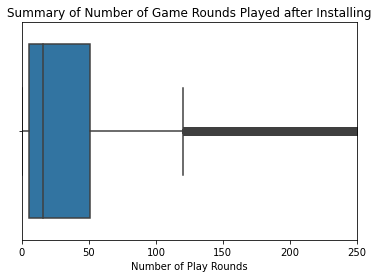

<Figure size 432x288 with 0 Axes>

In [36]:
# zoom in on x axis from 0 to 250
sns.boxplot(data=df, x='sum_gamerounds')
plt.xlim(0, 250)
plt.title('Summary of Number of Game Rounds Played after Installing')
plt.xlabel('Number of Play Rounds')
plt.show()
plt.clf()

According to the box plots above, we can confirm that the 'sum_gamerounds' column is highly left skewed, 75% of the data is lower than 51. Some users never played the game after installing. Now I will plot two distribution plots for the sun_playrounds data according to the versions.

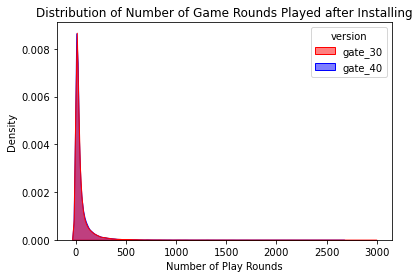

<Figure size 432x288 with 0 Axes>

In [41]:
sns.kdeplot(data=df, x='sum_gamerounds', hue='version', alpha=0.5, fill=True, palette=['red', 'blue'])
plt.title('Distribution of Number of Game Rounds Played after Installing')
plt.xlabel('Number of Play Rounds')
plt.show()
plt.clf()

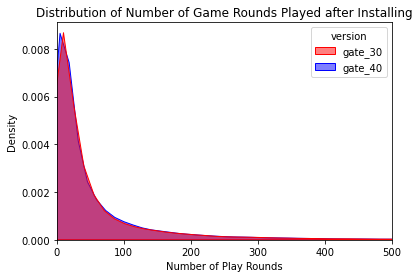

<Figure size 432x288 with 0 Axes>

In [42]:
sns.kdeplot(data=df, x='sum_gamerounds', hue='version', alpha=0.5, fill=True, palette=['red', 'blue'])
plt.xlim(0, 500)
plt.title('Distribution of Number of Game Rounds Played after Installing')
plt.xlabel('Number of Play Rounds')
plt.show()
plt.clf()

From the kde plots, we can see that the distributions for both version are quite similar, both right skewed and density the highest from 0 to 100.

Since for users who never played the game after installing, the retention rate will always be 0 in this project, it will not affect the significance. I will create sub dataframe with sum_playrounds greater than 0.

In [44]:
df_sub = df[df['sum_gamerounds'] > 0]

In [45]:
df_sub.shape

(86194, 5)

In [46]:
df_sub.describe(include='all')

,userid,version,sum_gamerounds,retention_1,retention_7
count,86194,86194,86194.000000,86194,86194
unique,86194,2,NaN,2,2
top,6397153,gate_40,NaN,False,False
freq,1,43432,NaN,46128,69443
mean,NaN,NaN,53.698297,NaN,NaN
std,NaN,NaN,104.425174,NaN,NaN
min,NaN,NaN,1.000000,NaN,NaN
25%,NaN,NaN,6.000000,NaN,NaN
50%,NaN,NaN,18.000000,NaN,NaN
75%,NaN,NaN,54.000000,NaN,NaN


### versions and retention_1 association

In [47]:
cont_tab = pd.crosstab(df_sub.version, df_sub.retention_1)
cont_tab

retention_1,False,True
version,,
gate_30,22769,19993
gate_40,23359,20073


In [49]:
chi2, pval, dof, expected = chi2_contingency(cont_tab)
print(pval)
print('Significant' if pval < 0.05 else 'Not significant')

0.11554308221600512
Not significant


### versions and retention_2 association

In [50]:
cont_tab_2 = pd.crosstab(df_sub.version, df_sub.retention_7)
cont_tab_2

retention_7,False,True
version,,
gate_30,34277,8485
gate_40,35166,8266


In [51]:
chi2, pval, dof, expected = chi2_contingency(cont_tab_2)
print(pval)
print('Significant' if pval < 0.05 else 'Not significant')

0.0027222297777463066
Significant
